<a href="https://colab.research.google.com/github/AAA0145/DesignOptimization2021Fall/blob/main/Project_1_update_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

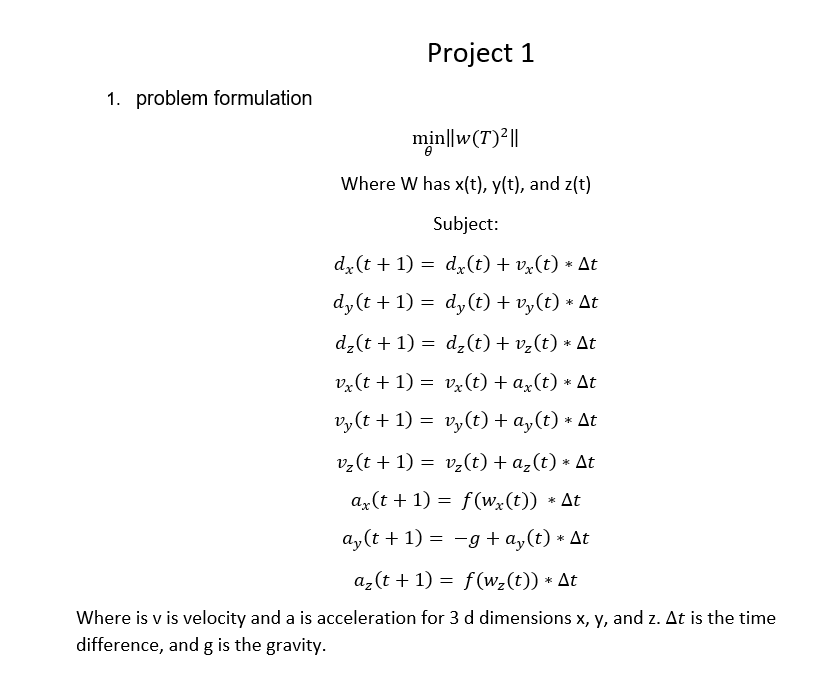

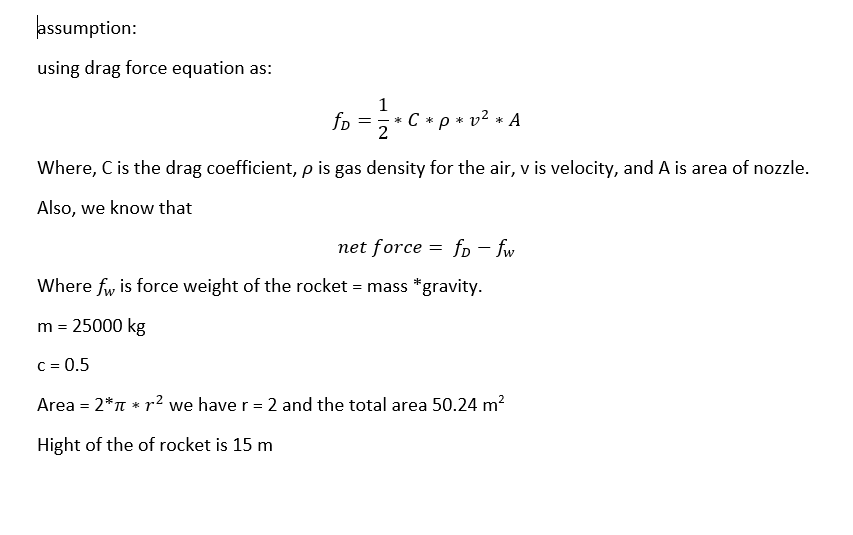

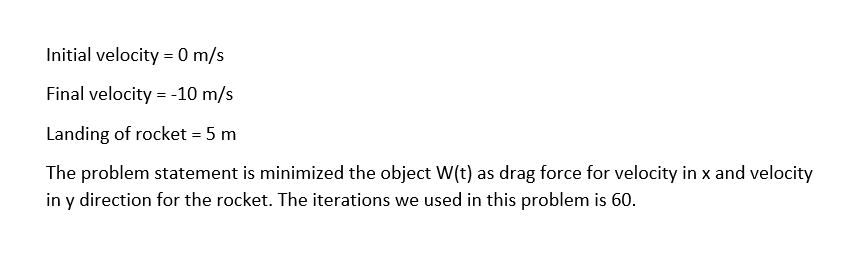


Itera: 1 loss: 886.21448


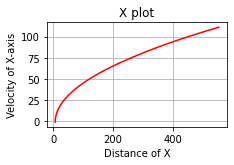


Itera: 2 loss: 702.12451


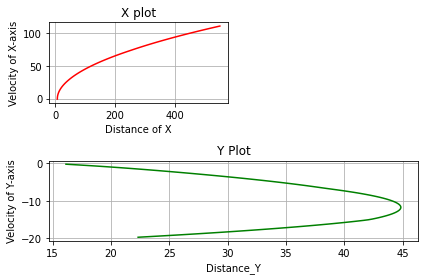


Itera: 3 loss: 592.22815


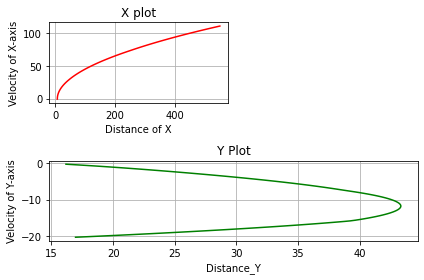


Itera: 4 loss: 519.90430


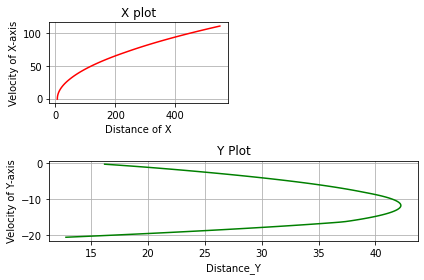


Itera: 5 loss: 442.54352


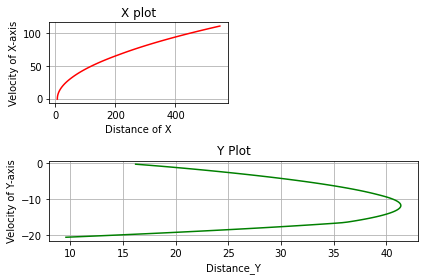


Itera: 6 loss: 175.98567


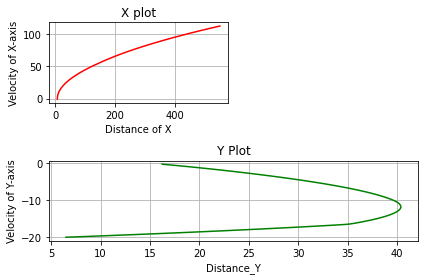


Itera: 7 loss: 89.55441


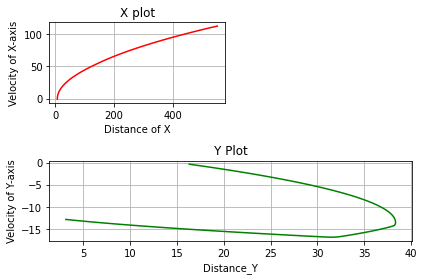


Itera: 8 loss: 44.16214


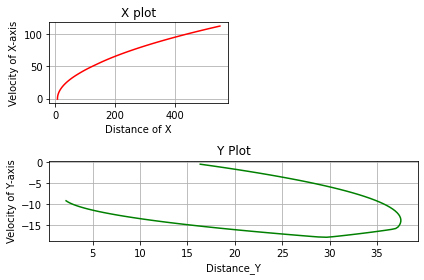


Itera: 9 loss: 22.84946


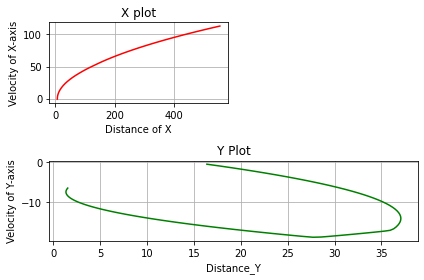


Itera: 10 loss: 12.89675


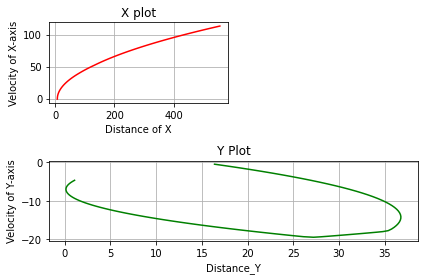


Itera: 11 loss: 7.58645


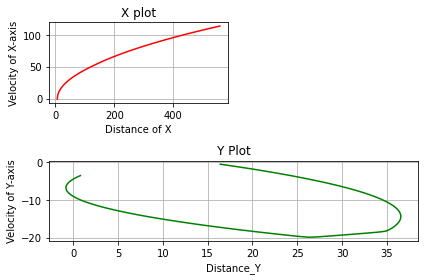


Itera: 12 loss: 4.57837


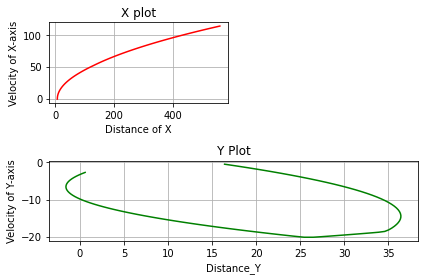


Itera: 13 loss: 2.85634


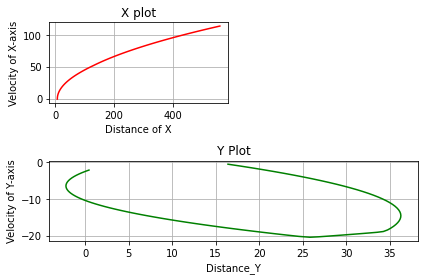


Itera: 14 loss: 1.78596


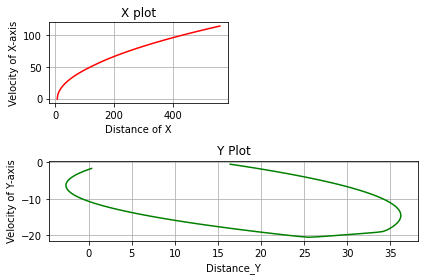


Itera: 15 loss: 1.10713


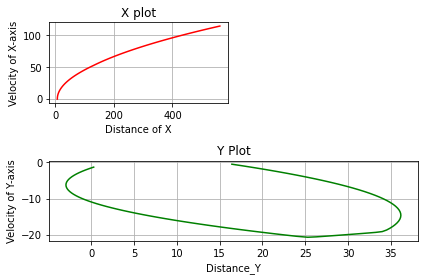


Itera: 16 loss: 0.67746


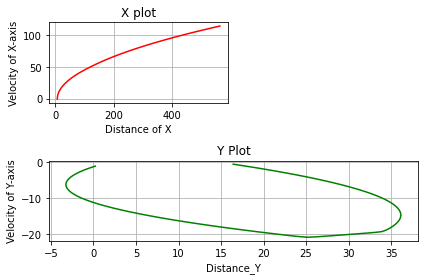


Itera: 17 loss: 0.41402


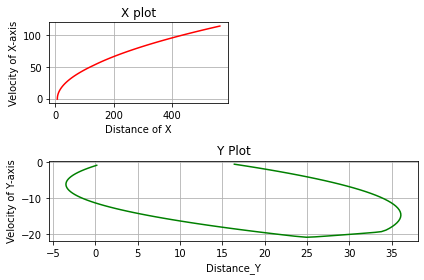


Itera: 18 loss: 0.25636


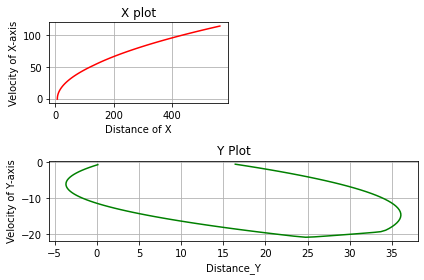


Itera: 19 loss: 0.15934


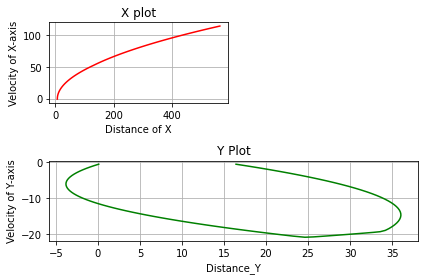


Itera: 20 loss: 0.09916


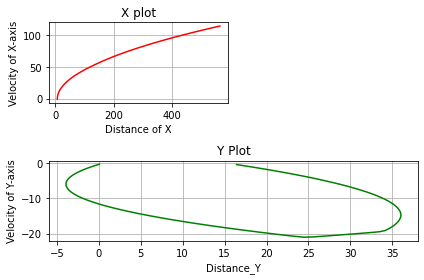


Itera: 21 loss: 0.06175


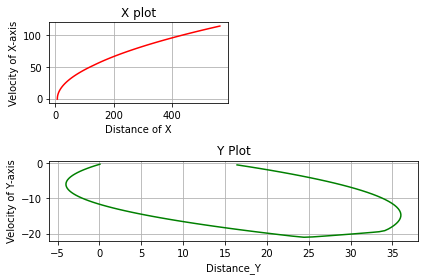


Itera: 22 loss: 0.03855


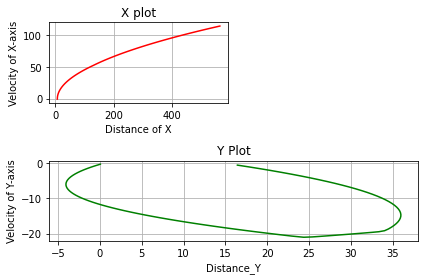


Itera: 23 loss: 0.02405


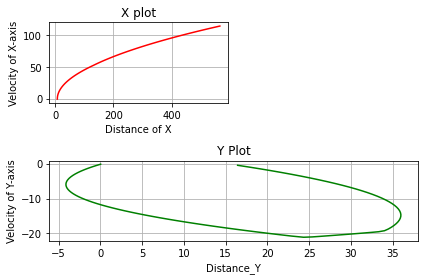


Itera: 24 loss: 0.01504


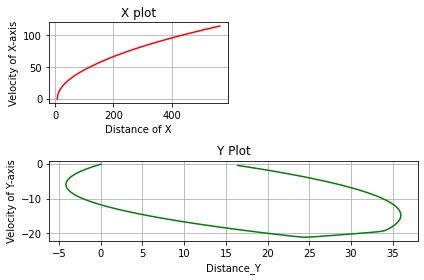


Itera: 25 loss: 0.00943


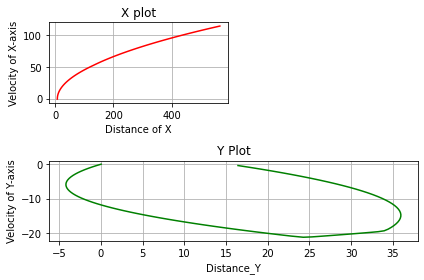


Itera: 26 loss: 0.00590


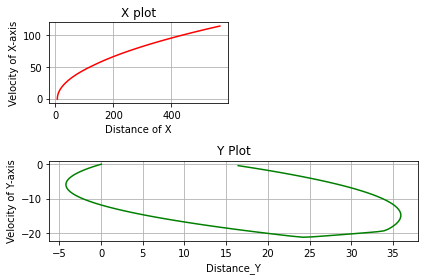


Itera: 27 loss: 0.00367


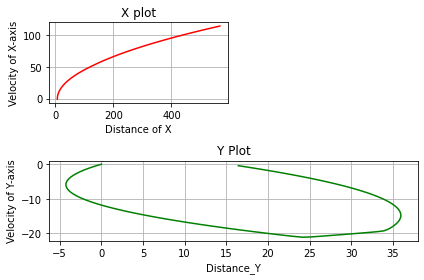


Itera: 28 loss: 0.00228


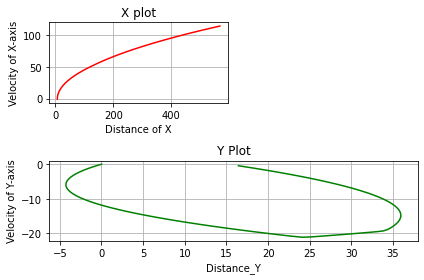


Itera: 29 loss: 0.00142


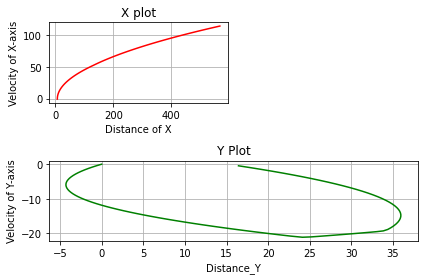


Itera: 30 loss: 0.00089


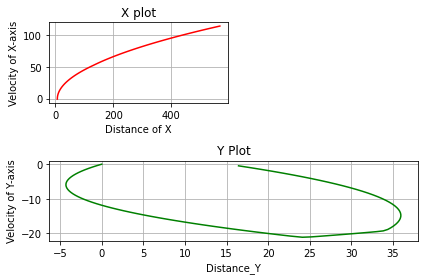


Itera: 31 loss: 0.00055


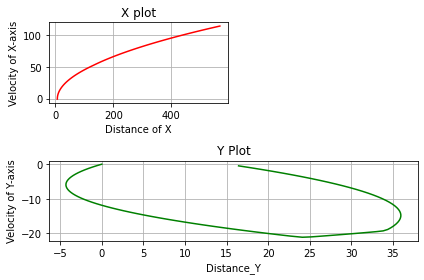


Itera: 32 loss: 0.00035


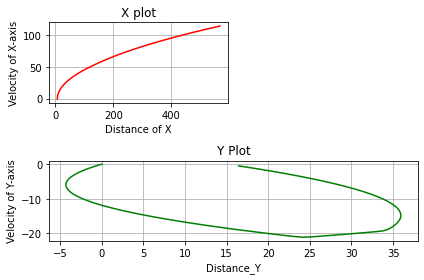


Itera: 33 loss: 0.00022


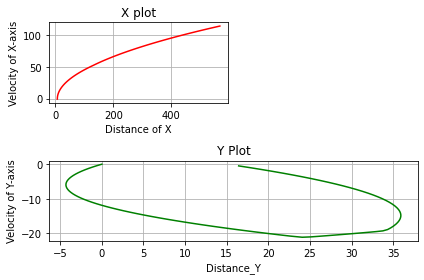


Itera: 34 loss: 0.00014


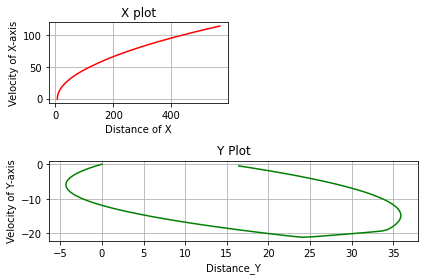


Itera: 35 loss: 0.00009


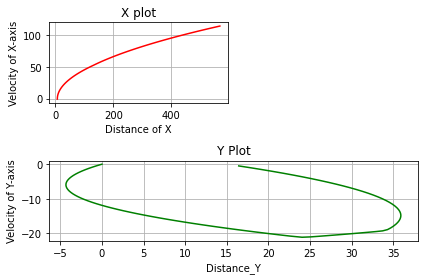


Itera: 36 loss: 0.00006


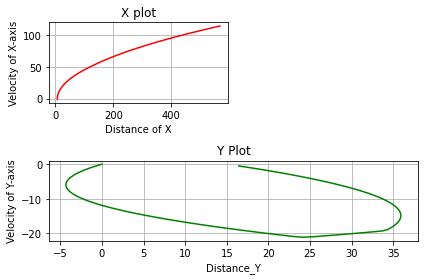


Itera: 37 loss: 0.00004


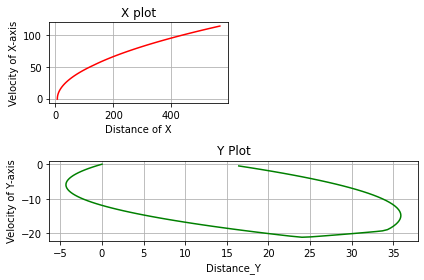


Itera: 38 loss: 0.00002


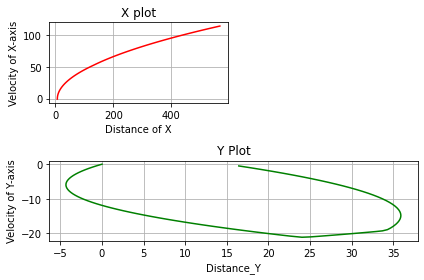


Itera: 39 loss: 0.00002


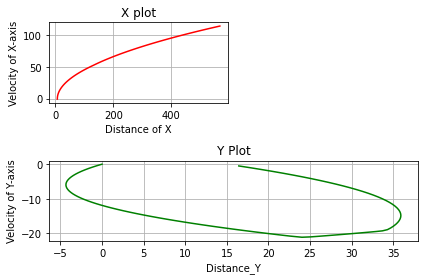


Itera: 40 loss: 0.00001


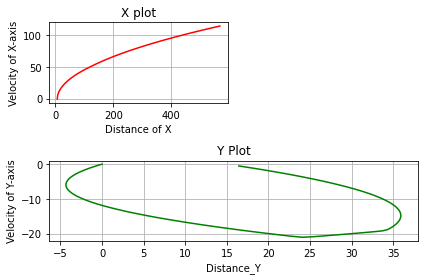


Itera: 41 loss: 0.00001


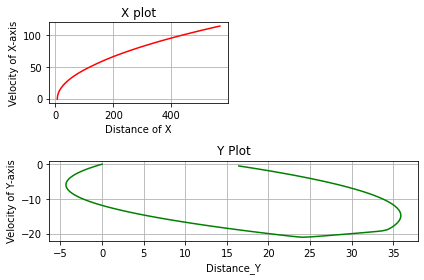


Itera: 42 loss: 0.00000


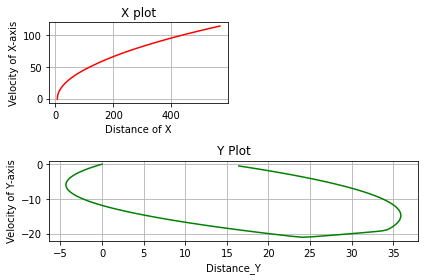


Itera: 43 loss: 0.00000


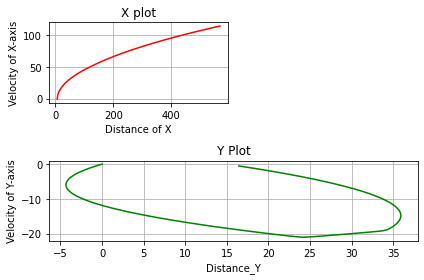


Itera: 44 loss: 0.00000


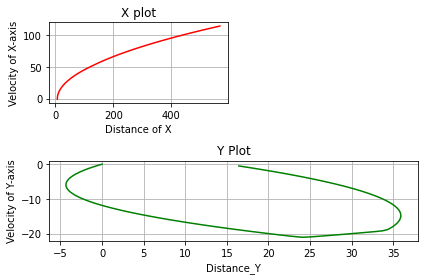


Itera: 45 loss: 0.00000


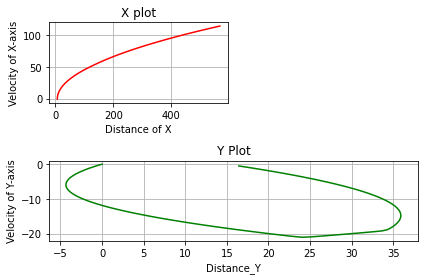


Itera: 46 loss: 0.00000


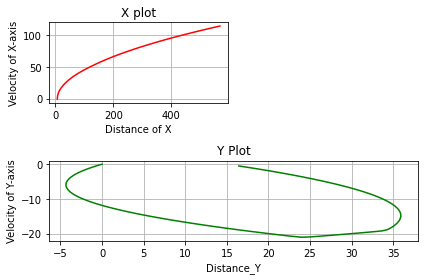


Itera: 47 loss: 0.00000


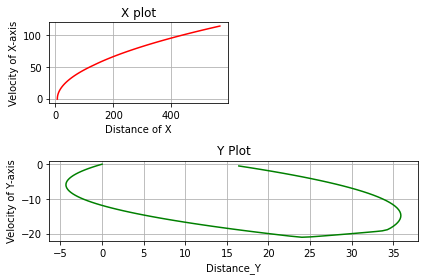


Itera: 48 loss: 0.00000


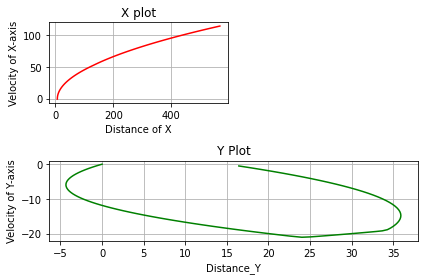


Itera: 49 loss: 0.00000


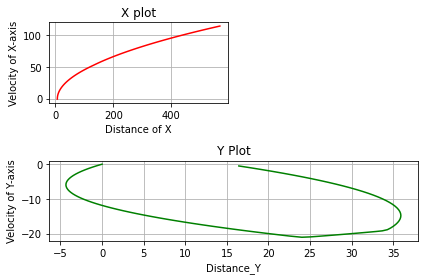


Itera: 50 loss: 0.00000


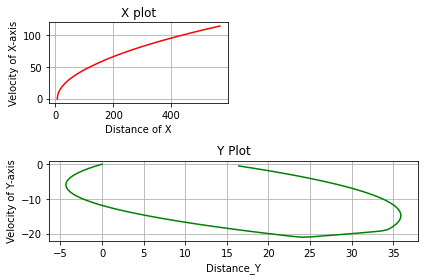


Itera: 51 loss: 0.00000


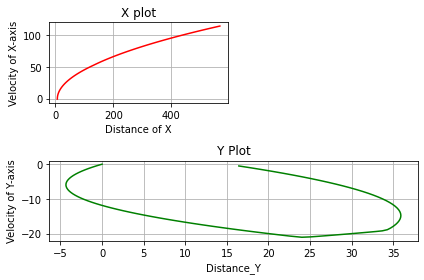


Itera: 52 loss: 0.00000


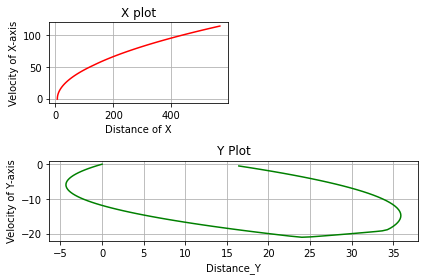


Itera: 53 loss: 0.00000


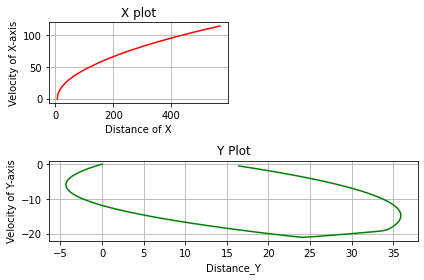


Itera: 54 loss: 0.00000


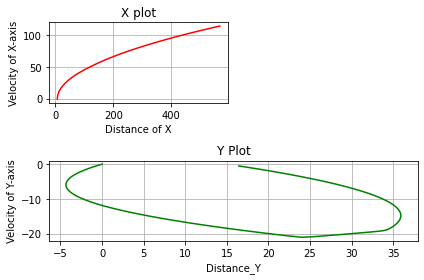


Itera: 55 loss: 0.00000


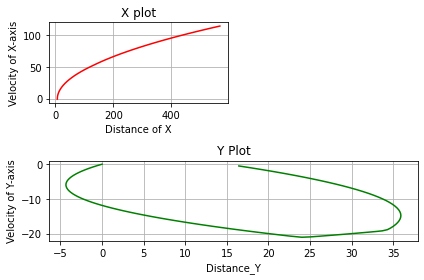


Itera: 56 loss: 0.00000


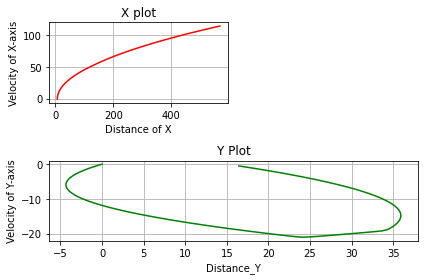


Itera: 57 loss: 0.00000


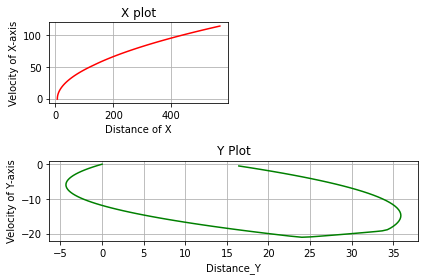


Itera: 58 loss: 0.00000


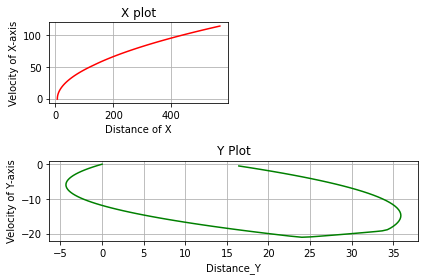


Itera: 59 loss: 0.00000


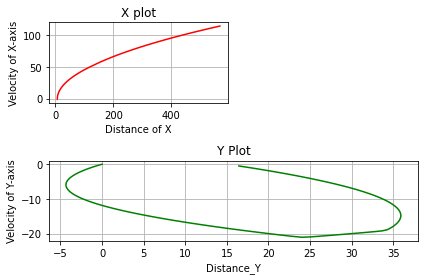


Itera: 60 loss: 0.00000


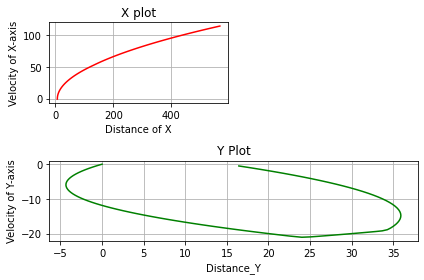

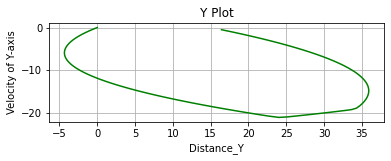

In [ ]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt


import numpy as np
logger = logging.getLogger(__name__)
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81  # gravity constant
BOOST_ACCEL = 20  # thrust constant
# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.


class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed...
        thrust_force_x = action[1]
        thrust_force_y = action[0]
        thrust_force_z = action[0]
        
        d_state_gravity = t.tensor([0.,FRAME_TIME * GRAVITY_ACCEL, 0., 0.]) 

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        d_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.]) *  thrust_force_x
        d_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) *  thrust_force_y
        d_state_z = BOOST_ACCEL * FRAME_TIME * t.tensor([1., 0., 0., 0.]) *  thrust_force_z
        
        constant  = 0.005
        total_ACCEL = - constant *(d_state_y)**2 + BOOST_ACCEL
        
        #Re-calculating new velocity in Y
        d_state_y = total_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * thrust_force_y

        # Update velocity
        state = state + d_state_y + d_state_gravity + d_state_x + d_state_z
         
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [15., 0., 7., -2.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('\nItera:',epoch+1,'loss: %.5f' % (loss))
           # print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        p = data[:, 3]
        
       

        plt.subplot(221)
        plt.title('X plot')
        plt.xlabel('Distance of X')
        plt.ylabel('Velocity of X-axis')
        plt.plot(z, p,'r')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure()
        plt.subplot(212)
        plt.title('Y Plot')
        plt.xlabel('Distance_Y')
        plt.ylabel('Velocity of Y-axis')
        plt.plot(x, y,'g')
        plt.grid(True)



# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions (y, y_dot, x, x_dot)
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions (a_y, a_x)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(60)  # solve the optimization problem

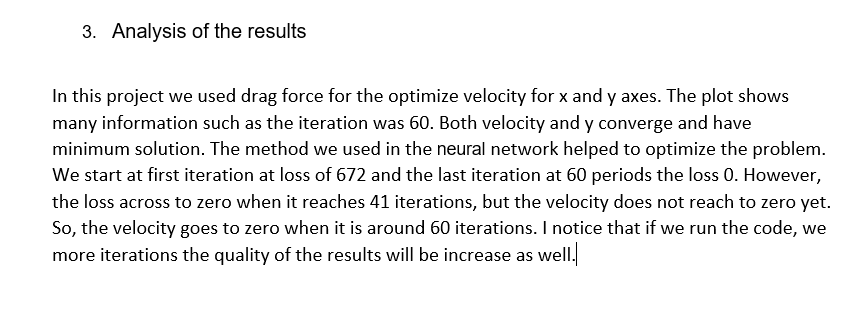

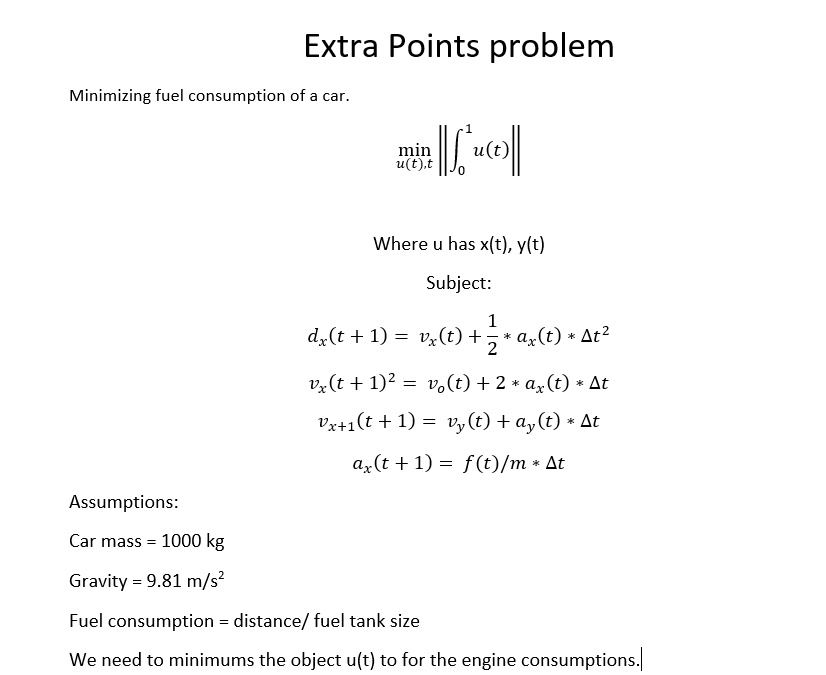


Itera: 1 loss: 127.57918


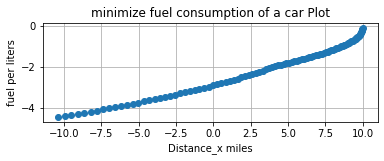


Itera: 2 loss: 83.87086


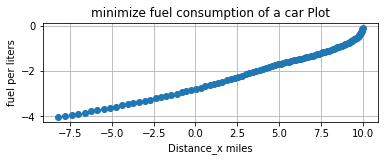


Itera: 3 loss: 51.64516


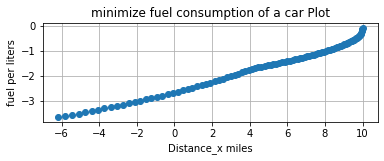


Itera: 4 loss: 31.01614


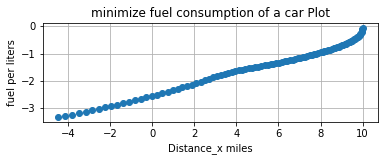


Itera: 5 loss: 19.91696


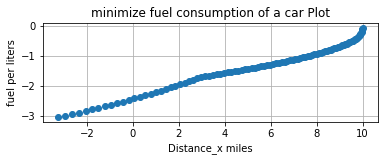


Itera: 6 loss: 13.76212


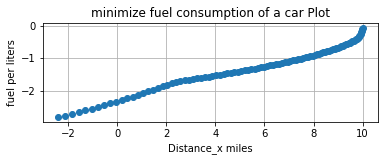


Itera: 7 loss: 9.99836


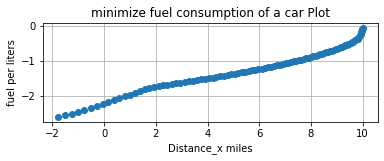


Itera: 8 loss: 7.36120


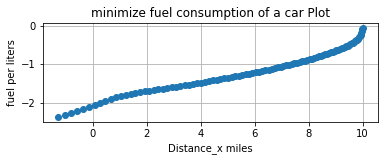


Itera: 9 loss: 5.46947


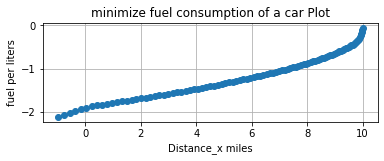


Itera: 10 loss: 4.58111


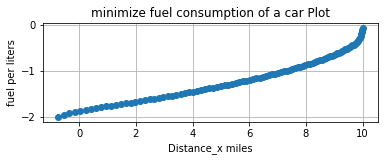


Itera: 11 loss: 4.06088


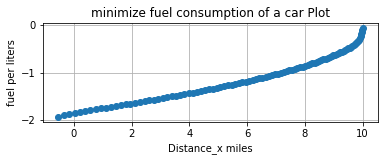


Itera: 12 loss: 3.72473


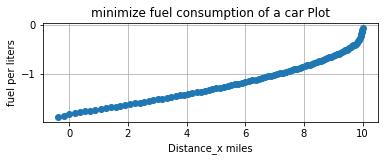


Itera: 13 loss: 3.49954


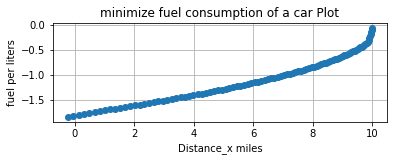


Itera: 14 loss: 3.34282


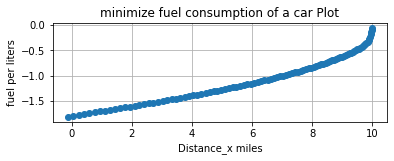


Itera: 15 loss: 3.23403


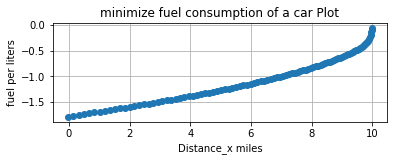


Itera: 16 loss: 3.15258


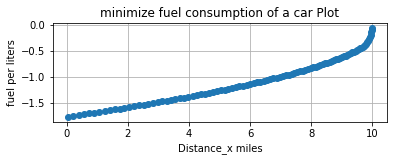


Itera: 17 loss: 3.08572


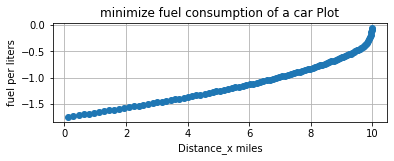


Itera: 18 loss: 3.02127


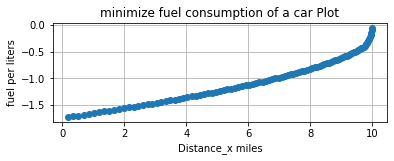


Itera: 19 loss: 2.93910


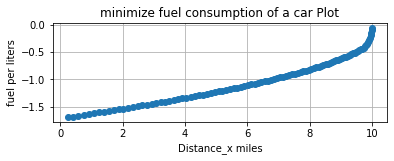


Itera: 20 loss: 2.68291


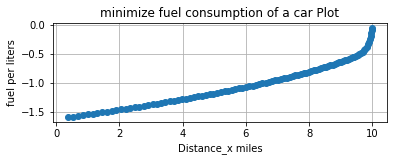


Itera: 21 loss: 1.82606


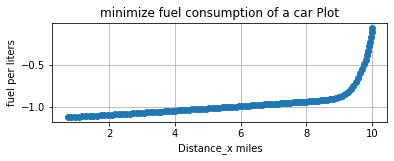


Itera: 22 loss: 0.26533


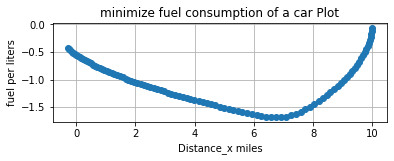


Itera: 23 loss: 0.21092


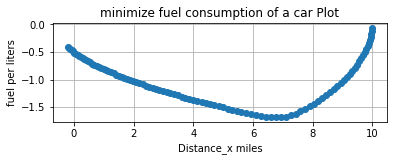


Itera: 24 loss: 0.15681


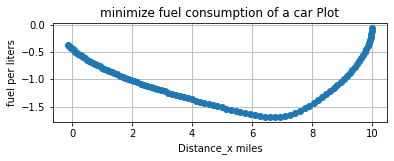


Itera: 25 loss: 0.11322


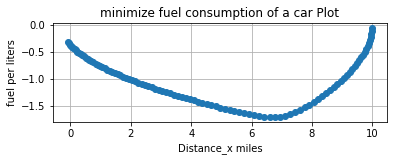


Itera: 26 loss: 0.08059


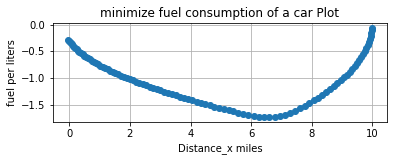


Itera: 27 loss: 0.05611


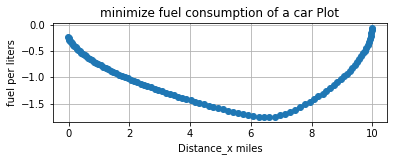


Itera: 28 loss: 0.03820


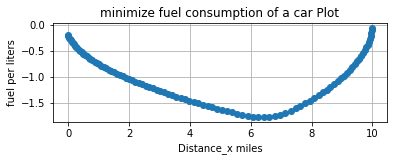


Itera: 29 loss: 0.02319


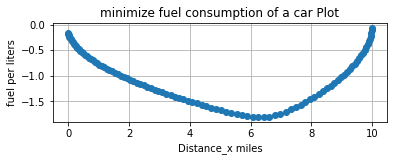


Itera: 30 loss: 0.01341


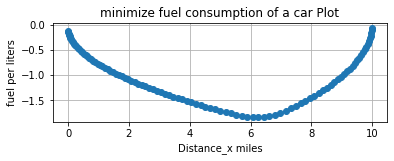


Itera: 31 loss: 0.00791


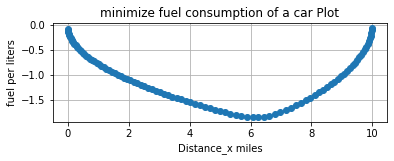


Itera: 32 loss: 0.00481


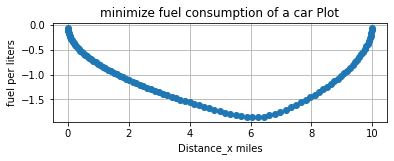


Itera: 33 loss: 0.00300


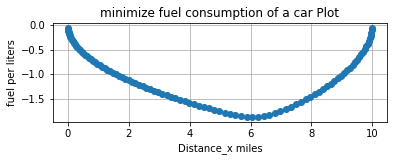


Itera: 34 loss: 0.00189


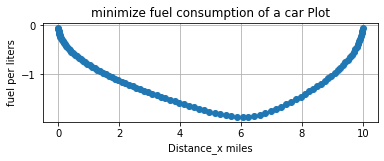


Itera: 35 loss: 0.00119


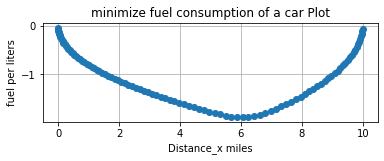


Itera: 36 loss: 0.00075


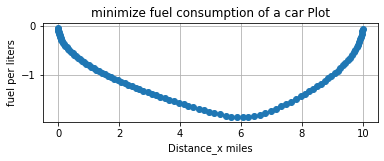


Itera: 37 loss: 0.00048


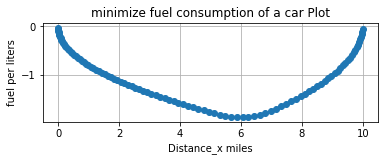


Itera: 38 loss: 0.00031


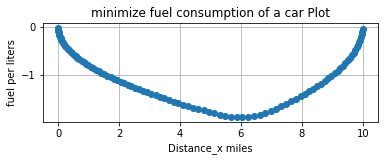


Itera: 39 loss: 0.00020


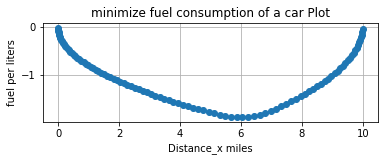


Itera: 40 loss: 0.00013


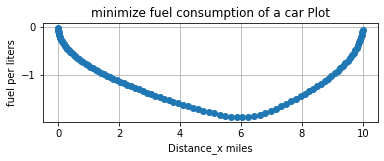


Itera: 41 loss: 0.00008


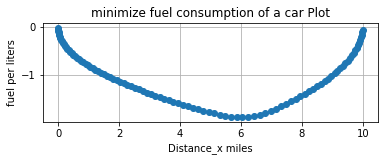


Itera: 42 loss: 0.00006


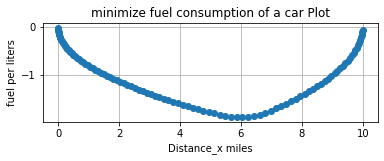


Itera: 43 loss: 0.00004


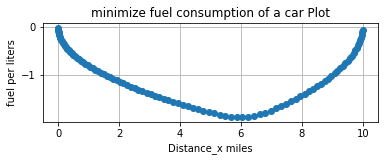


Itera: 44 loss: 0.00002


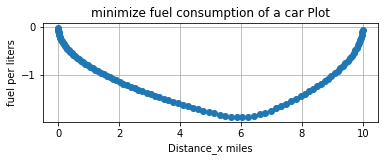


Itera: 45 loss: 0.00002


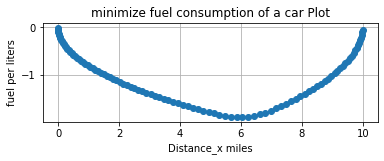


Itera: 46 loss: 0.00001


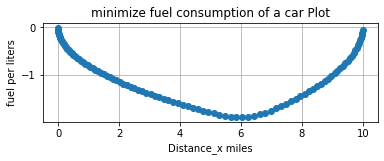


Itera: 47 loss: 0.00001


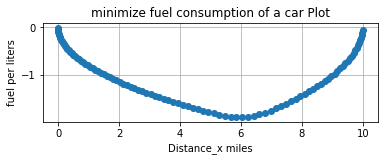


Itera: 48 loss: 0.00000


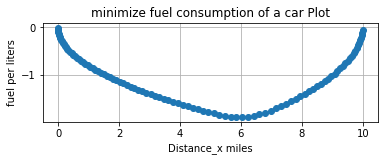


Itera: 49 loss: 0.00000


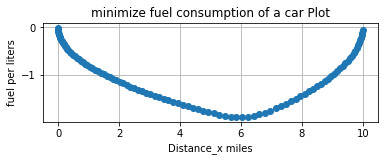


Itera: 50 loss: 0.00000


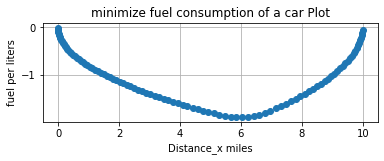


Itera: 51 loss: 0.00000


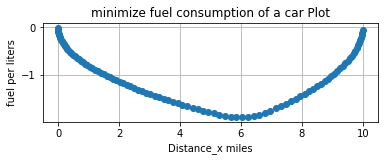


Itera: 52 loss: 0.00000


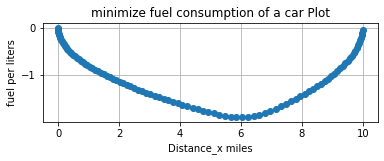


Itera: 53 loss: 0.00000


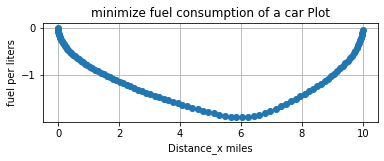


Itera: 54 loss: 0.00000


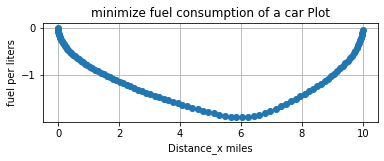


Itera: 55 loss: 0.00000


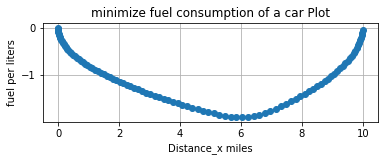


Itera: 56 loss: 0.00000


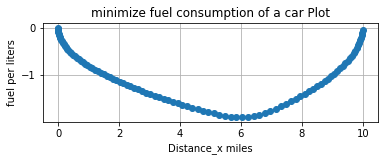


Itera: 57 loss: 0.00000


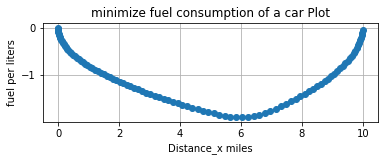


Itera: 58 loss: 0.00000


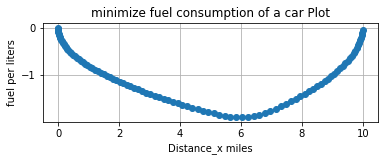


Itera: 59 loss: 0.00000


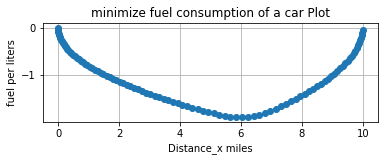


Itera: 60 loss: 0.00000


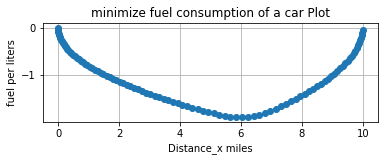

In [1]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special


import numpy as np
logger = logging.getLogger(__name__)
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81  # gravity constant
BOOST_ACCEL = 10  # thrust constant
# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.


class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed...
        
        
        m = 1000 # mass of the car
        fuel_car_tank = t.tensor([0.,1, 0., 0.]) 
        distance = 100
        constant  = 0.005
        u = -0.5*constant
        #result = integrate(u)
        d_state_gravity = t.tensor([0.,FRAME_TIME * GRAVITY_ACCEL, 0., 0.]) 
        thrust_force_x = action[1]
        thrust_force_y = action[0]
        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        d_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.]) *  thrust_force_x
        d_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) 
        
        u = -0.5*constant
        #result = integrate(u)

        constant  = 0.005
        total_ACCEL = - constant *(d_state_y)**2 + BOOST_ACCEL + 10
        
        #Re-calculating new velocity in Y
        d_state_y = total_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * thrust_force_y

        # Update velocity
        state = state + d_state_y + d_state_gravity + d_state_x 
         
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [10., 0., 7., 12.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('\nItera:',epoch+1,'loss: %.5f' % (loss))
           # print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        p = data[:, 3]
        
       

        

        plt.figure()
        plt.subplot(212)
        plt.title('minimize fuel consumption of a car Plot')
        plt.xlabel('Distance_x miles')
        plt.ylabel('fuel per liters')
        plt.plot(x, y,'o')
        plt.grid(True)
        plt.show()



# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions (y, y_dot, x, x_dot)
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions (a_y, a_x)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(60)  # solve the optimization problem

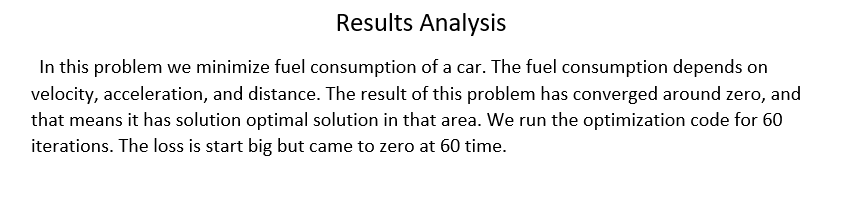